In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.utils import class_weight

cnn_results = {}
X_test_dict = {}
y_test_dict = {}
# Match window size to volatility periods
# window_sizes = [5, 22, 66, 126, 252]
window_size = 30  # Default window size for CNN

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    # Drop NA values
    df_model = market_sentiment_data.dropna(subset=feature_cols + ['future_crash']).copy()
    X_raw = df_model[feature_cols].fillna(0)
    y_raw = df_model['future_crash']

    # Flatten features (tabular form)
    X_flat = X_raw.values
    y_flat = y_raw.values

    # 1. Chronological split on raw (flattened) data
    train_size = int(len(X_flat) * 0.6)
    X_train_raw, y_train_raw = X_flat[:train_size], y_flat[:train_size]
    X_test_raw, y_test_raw = X_flat[train_size:], y_flat[train_size:]

    # 2. SMOTE only on training set
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train_raw, y_train_raw)

    # 3. Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_raw.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    # 4. Create sequences separately
    X_train, y_train, _ = create_sequences(X_train_resampled, y_train_resampled, window=window_size)
    X_test, y_test, _ = create_sequences(pd.DataFrame(X_test_raw, columns=X_raw.columns), pd.Series(y_test_raw), window=window_size)

    # # Apply SMOTE
    # X_resampled, y_resampled = sm.fit_resample(X_flat, y_flat)

    # X_resampled, y_resampled = X_flat.copy(), y_flat.copy()

    # # Convert back to DataFrame for convenience
    # X_resampled = pd.DataFrame(X_resampled, columns=X_raw.columns)
    # y_resampled = pd.Series(y_resampled, name='future_crash')

    # # Create time-series sequences
    # X_seq, y_seq, _ = create_sequences(X_resampled, y_resampled, window=window_size)

    # # Split train/test
    # X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, stratify=y_seq, test_size=0.2, random_state=RANDOM_STATE)


    # Define CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    # Train
    cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0, 
                  )

    # Predict
    y_prob = cnn_model.predict(X_test).flatten()
    plt.hist(y_prob, bins=50)
    plt.title("Distribution of CNN Output Probabilities")
    plt.show()

    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save model and results
    cnn_results[n] = {
        'model': cnn_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day CNN Model ===")
    print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

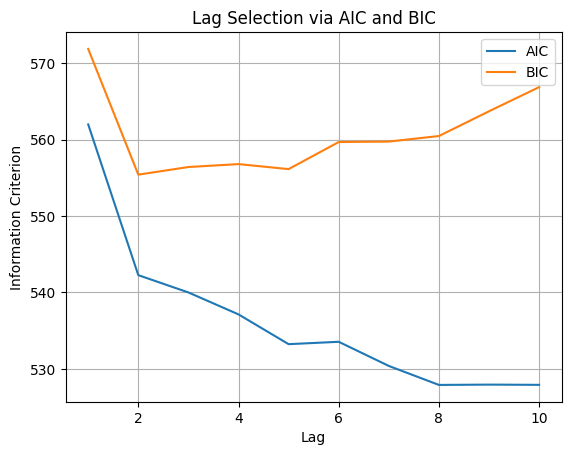

Best lag by AIC: 8
Best lag by BIC: 2


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import arma_order_select_ic

# Generate synthetic AR(3) data
np.random.seed(42)
n = 200
eps = np.random.normal(size=n)
y = np.zeros(n)

# Simulate AR(3): y[t] = 0.6*y[t-1] - 0.4*y[t-2] + 0.2*y[t-3] + noise
for t in range(3, n):
    y[t] = 0.6*y[t-1] - 0.4*y[t-2] + 0.2*y[t-3] + eps[t]

# Convert to pandas Series
series = pd.Series(y)

# Try different lag values and compare AIC/BIC
max_lag = 10
aic_vals = []
bic_vals = []

for lag in range(1, max_lag + 1):
    model = AutoReg(series, lags=lag).fit()
    aic_vals.append(model.aic)
    bic_vals.append(model.bic)

# Plot AIC and BIC
plt.plot(range(1, max_lag + 1), aic_vals, label='AIC')
plt.plot(range(1, max_lag + 1), bic_vals, label='BIC')
plt.xlabel('Lag')
plt.ylabel('Information Criterion')
plt.title('Lag Selection via AIC and BIC')
plt.legend()
plt.grid(True)
plt.show()

# Best lag according to AIC and BIC
best_aic_lag = np.argmin(aic_vals) + 1
best_bic_lag = np.argmin(bic_vals) + 1

print(f"Best lag by AIC: {best_aic_lag}")
print(f"Best lag by BIC: {best_bic_lag}")
